In [1]:
import os
import time
import sys
sys.path.append('..')  # Add parent folder to sys.path

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from data_sample import generate_example_data as data
from kernel import ARDKernel
import GP_CommonCalculation as GP
# from torch.autograd import Variable
import torch.optim as optim
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
# generate example data
xtr, ytr,xte,yte = data.generate(2000,100,seed=42)
xtr = xtr.to(dtype=torch.float64,device=device)
ytr = ytr.to(dtype=torch.float64, device=device)
xte = xte.to(dtype=torch.float64,device=device)

In [26]:
kernel= ARDKernel(1)

In [27]:
log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64, device=device) * -4)

In [28]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    n = xtr.shape[0]
    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)

    return -GP.Gaussian_log_likelihood(ytr,Sigma,Kinv_method='conjugate')

In [31]:
def forward(xtr, ytr, xte, kernel,log_beta):
    n_test = xte.size(0)


    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)

    K_s = kernel(xtr, xte)
    K_ss=kernel(xte,xte)
    mean,var=GP.conditional_Gaussian(ytr,Sigma,K_s,K_ss,Kinv_method="conjugate")
    var_diag=var.sum(dim = 0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)


    return mean,var_diag

In [32]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [34]:
train_adam(xtr, ytr, kernel, log_beta, niteration=100,lr=0.1)

iter 0 nll:107954.41532
iter 1 nll:80872.89368
iter 2 nll:64239.62418
iter 3 nll:52863.57460
iter 4 nll:44182.43623
iter 5 nll:37151.46441
iter 6 nll:31297.49897
iter 7 nll:26166.73908
iter 8 nll:21365.30573
iter 9 nll:16982.51224
iter 10 nll:13517.76069
iter 11 nll:11144.71451
iter 12 nll:9574.72975
iter 13 nll:8488.84795
iter 14 nll:7682.32606
iter 15 nll:7037.24315
iter 16 nll:6492.31769
iter 17 nll:6017.53101
iter 18 nll:5597.43069
iter 19 nll:5222.57975
iter 20 nll:4886.19333
iter 21 nll:4582.95333
iter 22 nll:4308.38617
iter 23 nll:4058.87609
iter 24 nll:3831.42785
iter 25 nll:3623.52182
iter 26 nll:3433.03519
iter 27 nll:3258.14154
iter 28 nll:3097.26712
iter 29 nll:2948.97528
iter 30 nll:2812.02630
iter 31 nll:2685.30988
iter 32 nll:2567.83800
iter 33 nll:2458.73258
iter 34 nll:2357.21054
iter 35 nll:2262.57434
iter 36 nll:2174.20241
iter 37 nll:2091.53861
iter 38 nll:2014.08452
iter 39 nll:1941.39393
iter 40 nll:1873.06578
iter 41 nll:1808.73981
iter 42 nll:1748.09090
iter 43 

In [35]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta)

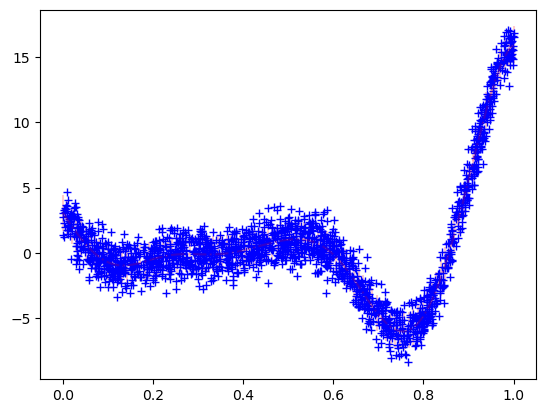

In [36]:
plt.errorbar(xte.cpu().numpy().reshape(100), ypred.detach().cpu().numpy().reshape(100),
             yerr=yvar.cpu().sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.cpu().numpy(), ytr.cpu().numpy(), 'b+')
plt.show()